In [1]:
# Imports

import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn import preprocessing
import scipy.stats

In [2]:
# Reading in pickle files

# File of all connectors with information about om, pre_type, etc
links = pd.read_pickle("/Users/deenashefter/Downloads/200506_linkdf.pickle", compression='infer')
df_links = pd.DataFrame(links)
# display(df_links)

# File of all connectors with their xyz coordinates
cx_coords = pd.read_pickle("/Users/deenashefter/Downloads/200506_cxcoords.pickle", compression='infer')
df_cx_coords = pd.DataFrame(cx_coords)
# display(df_cx_coords)

In [3]:
# Preprocessing function, making dataframe of index cx_id and pre_om, pre_type, coordinates

def preprocessing():
    df_new = df_links[['cx_id','pre_om','pre_type', 'post_om', 'post_type']]
    df_c = pd.merge(df_new, df_cx_coords.reset_index(), left_on='cx_id',right_on='index').drop(['index'], axis=1)
    df_comp = df_c[df_c.post_om != 'UNKNOWN'].drop_duplicates()
    df_comp.to_csv(r'C:\Documents\Flatiron Internship\Lamina Analysis\export_df.csv')
    return df_comp
    
df_comp = preprocessing()

In [4]:
# Function to do PCA

def do_PCA(coordinates):
    pca = PCA(n_components=1)
    pca.fit(coordinates)
    trans_all = pca.transform(coordinates)
    normalized = (trans_all-np.min(trans_all))/(np.max(trans_all)-np.min(trans_all))
    return normalized

In [5]:
# Function to flip orientation

def flip_PCA(dfd):
    pre_oms = dfd['pre_om'].unique()

    for o in pre_oms:
#         print(o)
        dfo = dfd.loc[dfd['pre_om'] == o]
        dfmin = dfo.loc[dfo['x'] == min(dfo['x'])]
        dfmin = dfmin[['x','transformed_coords']]
        dfmax = dfo.loc[dfo['x'] == max(dfo['x'])]
        dfmax = dfmax[['x','transformed_coords']]
#         display(dfmin, dfmax)
        
        if dfmin['transformed_coords'].min() < dfmax['transformed_coords'].max():
            continue
        else:
            dfd.loc[dfd['pre_om'] == o, 'transformed_coords'] = 1 - dfd.loc[dfd['pre_om'] == o, 'transformed_coords']
    return dfd

In [9]:
# Makes df with transformed coords

dfd = df_comp.copy()
dfd["transformed_coords"] = np.nan
for om, rows in df_comp.groupby('pre_om'):
    coords = rows.loc[:, ['x', 'y', 'z']]
    normalized = do_PCA(coords)
    norm_list = [x[0] for x in normalized]
    dfd.loc[dfd["pre_om"]==om,"transformed_coords"] = norm_list

# display(dfd)
dfd_final = flip_PCA(dfd)
# display(dfd_final)
# print("should be flipped")
# display(dfd_flipped)

In [10]:
# Comparing untransformed/transformed coordinates

# df = dfd.loc[dfd['pre_type'] == 'LMC_2']
df = dfd

pre_oms = dfd['pre_om'].unique()

for o in pre_oms:
    dfo = df.loc[df['pre_om'] == o]
    dft = dfo.loc[dfo['transformed_coords'] == max(dfo['transformed_coords'])]
    dft = dft[['x','transformed_coords']]
    print(o)
    print("--------PRINTING DF WHERE X IS MIN-----------")
    dfmin = dfo.loc[dfo['x'] == min(dfo['x'])]
    dfmin = dfmin[['x','transformed_coords']]
    display(dfmin)
    print("--------PRINTING DF WHERE X IS MAX-----------")
    dfmax = dfo.loc[dfo['x'] == max(dfo['x'])]
    dfmax = dfmax[['x','transformed_coords']]
    display(dfmax)

B6
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
10231,28320.0,0.0
10232,28320.0,0.0
10233,28320.0,0.0
10234,28320.0,0.0
10236,28320.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
5,35203.0,1.0


E7
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
19459,29375.0,0.0
19460,29375.0,0.0
19461,29375.0,0.0
19462,29375.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
6,35680.0,1.0
7,35680.0,1.0


A3
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
684,30120.0,0.046401
685,30120.0,0.046401
687,30120.0,0.046401
688,30120.0,0.046401
689,30120.0,0.046401


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
17215,35023.0,1.0
17216,35023.0,1.0
17217,35023.0,1.0


B3
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
95,30328.0,0.171388
97,30328.0,0.171388
98,30328.0,0.171388


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
2642,34832.0,0.967549
2643,34832.0,0.967549
2644,34832.0,0.967549
2645,34832.0,0.967549
2646,34832.0,0.967549
2647,34832.0,0.967549


B2
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
4182,27248.0,0.148473
4183,27248.0,0.148473


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
5199,32552.0,1.0
5200,32552.0,1.0
5201,32552.0,1.0
5206,32552.0,1.0


D5
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
7277,30411.0,0.0
7278,30411.0,0.0
7279,30411.0,0.0
7281,30411.0,0.0
7282,30411.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
7327,37552.0,0.919126
7328,37552.0,0.919126
7329,37552.0,0.919126


C4
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
4020,29517.5,0.0
4021,29517.5,0.0
4022,29517.5,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
1316,36776.0,0.977956
1317,36776.0,0.977956
1318,36776.0,0.977956
1320,36776.0,0.977956


B5
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
9285,28528.0,0.0
9286,28528.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
16709,37104.0,1.0
16710,37104.0,1.0
16711,37104.0,1.0


C6
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
2124,30216.0,0.0
2125,30216.0,0.0
2126,30216.0,0.0
2127,30216.0,0.0
2128,30216.0,0.0
2129,30216.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
2345,36537.2,1.0
2346,36537.2,1.0
2347,36537.2,1.0


A2
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
4078,28250.0,0.177447
4079,28250.0,0.177447
4080,28250.0,0.177447


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
2915,32100.0,0.79488
2917,32100.0,0.79488


C3
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
3451,29424.0,0.07825
3452,29424.0,0.07825
3453,29424.0,0.07825
3454,29424.0,0.07825
3455,29424.0,0.07825
3456,29424.0,0.07825


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
3863,33628.0,0.931464
3864,33628.0,0.931464
3867,33628.0,0.931464
3868,33628.0,0.931464
3870,33628.0,0.931464


D4
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
5798,29878.0,0.060664
5799,29878.0,0.060664
5800,29878.0,0.060664
5801,29878.0,0.060664


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
4816,35840.0,0.936422
4817,35840.0,0.936422


B4
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
5493,31364.0,0.0
5495,31364.0,0.0
5497,31364.0,0.0
5498,31364.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
5384,36716.0,0.894812
5385,36716.0,0.894812
5387,36716.0,0.894812
5388,36716.0,0.894812


E5
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
4882,29825.0,0.0
4883,29825.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
4891,36195.0,0.959708


D3
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
7459,26632.3,0.17333
7462,26632.3,0.17333


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
7438,31653.8,0.849032
7439,31653.8,0.849032
7440,31653.8,0.849032
7443,31653.8,0.849032


D6
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
8305,29840.0,0.0
8306,29840.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
8243,37504.0,1.0
8245,37504.0,1.0
8246,37504.0,1.0
8247,37504.0,1.0
8248,37504.0,1.0


E4
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
9149,28051.0,0.116428
9150,28051.0,0.116428
9151,28051.0,0.116428


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
8470,31590.0,0.868176
8471,31590.0,0.868176
8472,31590.0,0.868176
8473,31590.0,0.868176
8474,31590.0,0.868176
8475,31590.0,0.868176


C5
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
11650,31016.0,0.0
11651,31016.0,0.0
11652,31016.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
9855,39065.0,1.0
9856,39065.0,1.0


A0
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
18139,25265.0,0.121864
18141,25265.0,0.121864
18142,25265.0,0.121864


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
10067,28688.0,0.898766
10068,28688.0,0.898766


A5
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
11633,28548.0,0.0
11635,28548.0,0.0
11637,28548.0,0.0
11640,28548.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
11761,34600.0,0.966187
11763,34600.0,0.966187
11764,34600.0,0.966187


D2
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
15322,25940.0,0.220225
15328,25940.0,0.220225
15331,25940.0,0.220225
15333,25940.0,0.220225


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
14521,29060.0,0.947013
14522,29060.0,0.947013
14523,29060.0,0.947013
14528,29060.0,0.947013


A1
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
12072,26104.0,0.150185
12073,26104.0,0.150185
12074,26104.0,0.150185
12076,26104.0,0.150185


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
11829,30790.0,1.0
11830,30790.0,1.0
11833,30790.0,1.0


B0
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
12336,24176.0,0.184482
12337,24176.0,0.184482
12338,24176.0,0.184482
12340,24176.0,0.184482
12341,24176.0,0.184482
12342,24176.0,0.184482


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
13022,27030.0,1.0
13023,27030.0,1.0
13024,27030.0,1.0
13025,27030.0,1.0


E6
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
13683,30859.0,0.0
13684,30859.0,0.0
13686,30859.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
13678,36880.0,1.0
13679,36880.0,1.0
13680,36880.0,1.0
13682,36880.0,1.0


A4
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
15396,30076.0,0.0
15397,30076.0,0.0
15398,30076.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
14712,35825.0,0.915874
14713,35825.0,0.915874
14715,35825.0,0.915874
14716,35825.0,0.915874


B1
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
19505,25477.0,0.18292
19507,25477.0,0.18292
19508,25477.0,0.18292
19509,25477.0,0.18292


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
18978,30490.0,1.0
18979,30490.0,1.0
18981,30490.0,1.0


C1
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
17356,24784.0,0.0
17357,24784.0,0.0
17358,24784.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
17373,29160.0,1.0
17374,29160.0,1.0
17375,29160.0,1.0


D7
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
17995,28984.0,0.0


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
17218,35392.0,1.0
17219,35392.0,1.0
17220,35392.0,1.0
17221,35392.0,1.0
17222,35392.0,1.0


C2
--------PRINTING DF WHERE X IS MIN-----------


,x,transformed_coords
20493,26800.0,0.132716
20496,26800.0,0.132716


--------PRINTING DF WHERE X IS MAX-----------


,x,transformed_coords
20470,31840.0,1.0
20471,31840.0,1.0
20472,31840.0,1.0
20473,31840.0,1.0
20475,31840.0,1.0


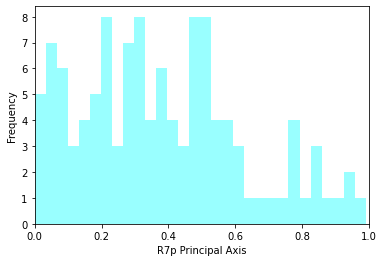

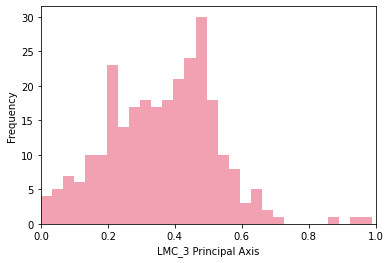

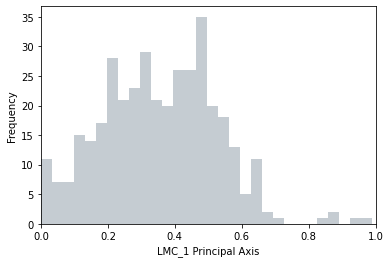

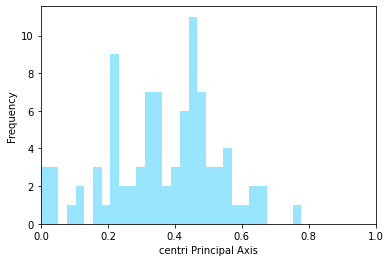

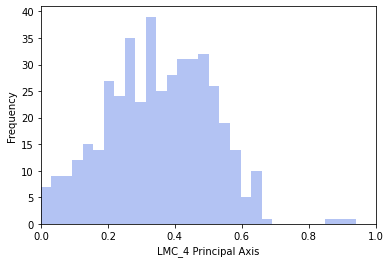

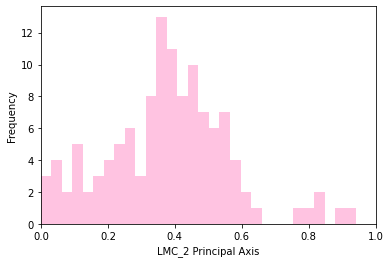

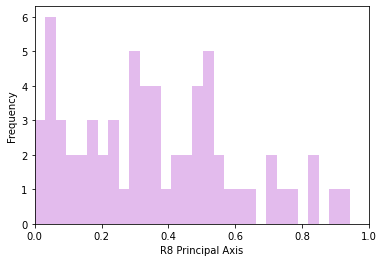

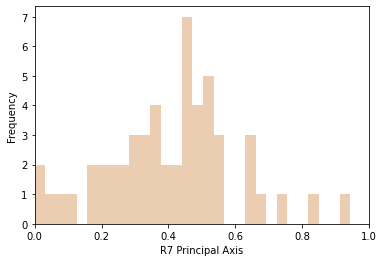

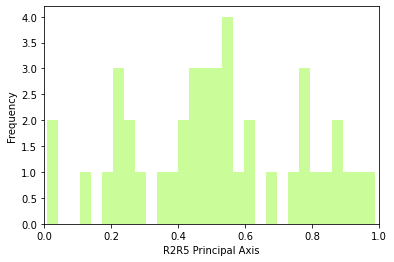

In [11]:
# Histograms - L2 pre
colors = {'LMC_N': 'tomato', 'centri': 'deepskyblue', 'R2R5': 'lawngreen', 'R3R6': 'gold', 'R1R4': 'orange', 'LMC_1': 'slategrey', 'LMC_3': 'crimson', 'LMC_2': 'hotpink', 'R7p': 'cyan', 'R8': 'mediumorchid', 'LMC_4': 'royalblue', 'R7': 'peru'}

df = dfd.loc[dfd['pre_type'] == 'LMC_2']
di = {}
for index, row in df.iterrows():
    if row['post_type'] not in ['LMC_N', 'R1R4', 'R3R6']:
        if row['post_type'] not in di:
            di[row['post_type']] = [row['transformed_coords']]
        else:
            di[row['post_type']].append(row['transformed_coords'])
    
for key,value in di.items():
    sns.distplot(value, bins=30, color=colors[key], kde=False)
    plt.xlabel(str(key) + " Principal Axis")
    plt.ylabel("Frequency")
    plt.xlim(0, 1)
#     plt.ylim(0, 40)
    plt.show()

In [12]:
sdf = pd.DataFrame()
sdf['type'] = di.keys()

s_li = []

for key,value in di.items():
    s = scipy.stats.skew(value)
    s_li.append(s)
    
sdf['skew'] = s_li
    
display(sdf)
    

,type,skew
0,R7p,0.477484
1,LMC_3,0.200399
2,LMC_1,0.211330
3,centri,-0.256156
4,LMC_4,0.066052
5,LMC_2,0.298686
6,R8,0.460819
7,R7,0.134936
8,R2R5,-0.049865


In [7]:
# Histograms - L2 pre
# colors = {'LMC_N': 'tomato', 'centri': 'deepskyblue', 'R2R5': 'lawngreen', 'R3R6': 'gold', 'R1R4': 'orange', 'LMC_1': 'slategrey', 'LMC_3': 'crimson', 'LMC_2': 'hotpink', 'R7p': 'cyan', 'R8': 'mediumorchid', 'LMC_4': 'royalblue', 'R7': 'peru'}

df = dfd.loc[dfd['pre_type'] == 'LMC_2']
di = {}
for index, row in df.iterrows():
    if row['pre_om'] not in di:
        di[row['pre_om']] = [row['transformed_coords']]
    else:
        di[row['pre_om']].append(row['transformed_coords'])
    
for key,value in di.items():
    
    sns.distplot(value, bins=10, kde=False)
    plt.xlabel(str(key) + " Principal Axis")
    plt.ylabel("Frequency")
    plt.xlim(0, 1)
#     plt.ylim(0, 40)
    plt.show()

NameError: name 'dfd' is not defined

In [10]:
sdf = pd.DataFrame()
sdf['om'] = di.keys()

s_li = []

for key,value in di.items():
    s = scipy.stats.skew(value)
    s_li.append(s)
    
sdf['skew'] = s_li
    
display(sdf)

,om,skew
0,A3,-0.198386
1,C4,0.084203
2,B6,-0.291444
3,C6,-0.461559
4,B3,1.202078
5,C3,0.564857
6,A2,0.138427
7,B2,0.268720
8,D4,0.220410
9,B4,-0.031665


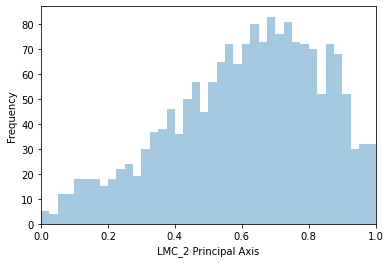

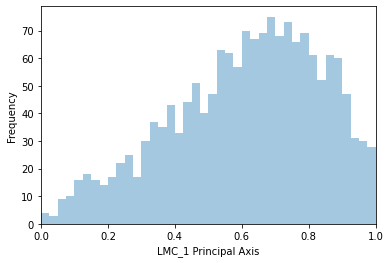

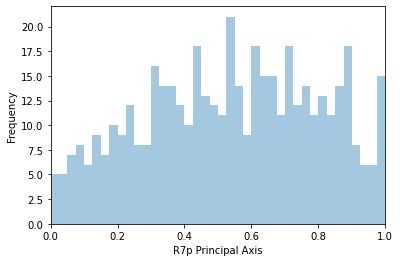

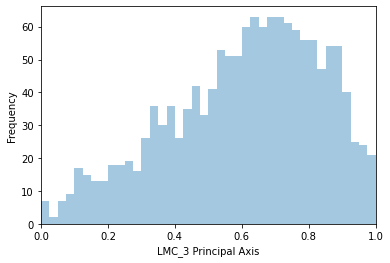

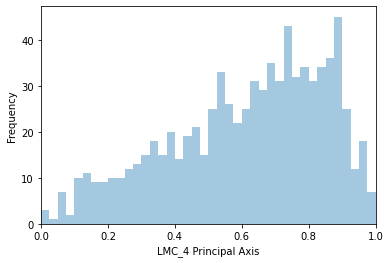

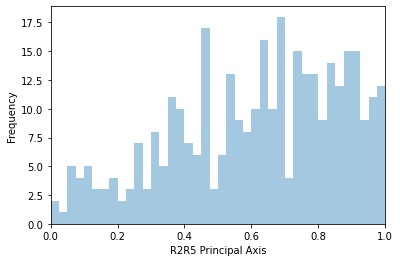

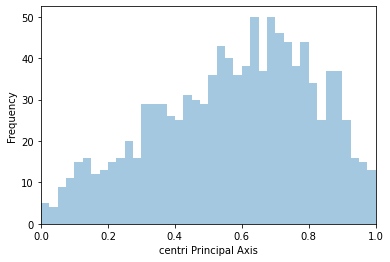

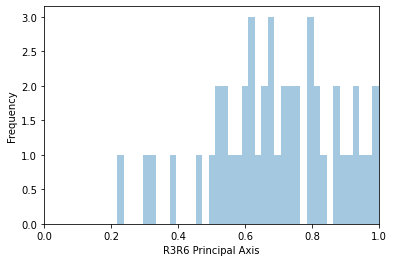

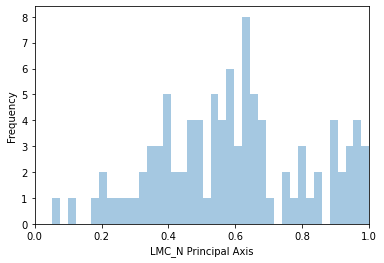

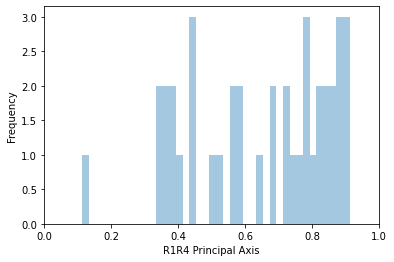

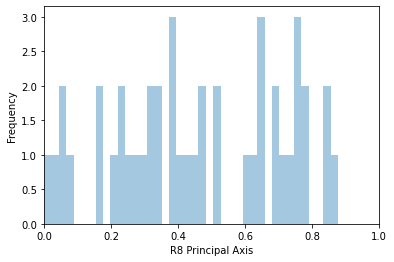

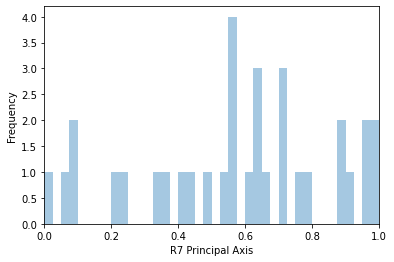

In [11]:
# Histograms - PR->everything

df_R1R4, df_R2R5, df_R3R6 = dfd.loc[(dfd['pre_type'] == 'R1R4')], dfd.loc[(dfd['pre_type'] == 'R2R5')], dfd.loc[(dfd['pre_type'] == 'R3R6')]
df_PR = df_R1R4.append([df_R2R5, df_R3R6])
di_PR = {}
for index, row in df_PR.iterrows():
    if row['post_type'] not in di_PR:
        di_PR[row['post_type']] = [row['transformed_coords']]
    else:
        di_PR[row['post_type']].append(row['transformed_coords'])

for key,value in di_PR.items():
    
    sns.distplot(value, bins=40, kde=False)
    plt.xlabel(str(key) + " Principal Axis")
    plt.ylabel("Frequency")
    plt.xlim(0, 1)
#     plt.ylim(0, 40)
    plt.show()

/Users/deenashefter/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



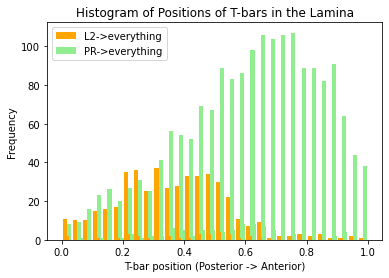

In [13]:
# Histograms - L2 pre and PR pre
colors = {'LMC_N': 'tomato', 'centri': 'deepskyblue', 'R2R5': 'lawngreen', 'R3R6': 'gold', 'R1R4': 'orange', 'LMC_1': 'slategrey', 'LMC_3': 'crimson', 'LMC_2': 'hotpink', 'R7p': 'cyan', 'R8': 'mediumorchid', 'LMC_4': 'royalblue', 'R7': 'peru'}

df_L2 = dfd.loc[dfd['pre_type'] == 'LMC_2']
di_L2 = {}
for index, row in df_L2.iterrows():
    if row['post_type'] not in ['LMC_N', 'R1R4', 'R3R6']:
        if row['post_type'] not in di_L2:
            di_L2[row['post_type']] = [row['transformed_coords']]
        else:
            di_L2[row['post_type']].append(row['transformed_coords'])

df_R1R4, df_R2R5, df_R3R6 = dfd.loc[(dfd['pre_type'] == 'R1R4')], dfd.loc[(dfd['pre_type'] == 'R2R5')], dfd.loc[(dfd['pre_type'] == 'R3R6')]
df_PR = df_R1R4.append([df_R2R5, df_R3R6])
di_PR = {}
for index, row in df_PR.iterrows():
    if row['post_type'] not in di_PR:
        di_PR[row['post_type']] = [row['transformed_coords']]
    else:
        di_PR[row['post_type']].append(row['transformed_coords'])


for (k,v), (k2,v2) in zip(di_L2.items(), di_PR.items()):
    labels = ('L2->everything', 'PR->everything')
    plt.hist([v,v2], bins=30, alpha=1, color=['orange','lightgreen'])
    plt.legend(labels, loc='upper left')
    plt.title('Histogram of Positions of T-bars in the Lamina')
    plt.xlabel('T-bar position (Posterior -> Anterior)')
    plt.ylabel("Frequency")
    plt.legend(labels, loc='upper left')
    
# for (k,v), (k2,v2) in zip(di_L2.items(), di_PR.items()):
#     labels = ('L2->everything', 'PR->everything')
#     sns.distplot(v, bins=30, color='orange')
#     sns.distplot(v2, bins=30, color='lightgreen')
#     plt.legend(labels, loc='upper left')
#     plt.xlabel("Principal Axis")
#     plt.ylabel("Frequency")
#     plt.legend(labels, loc='upper left')

(1.0, 0.0)

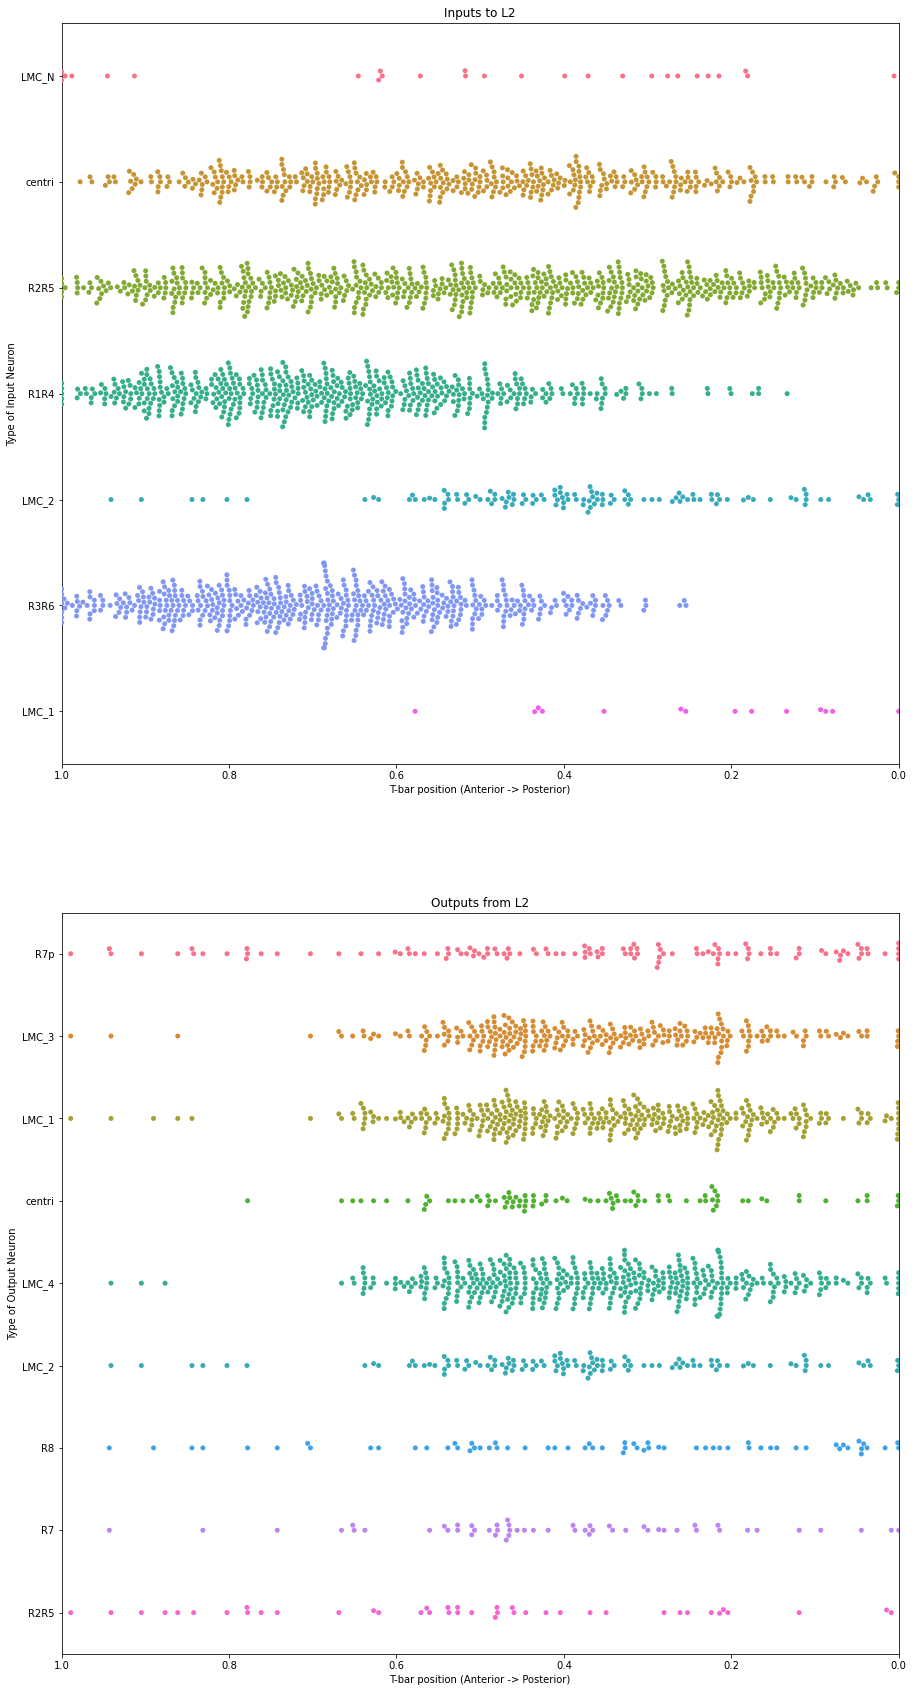

In [14]:
# Swarmplot

fig, ax = plt.subplots(2, figsize=[15, 30])

#L2 inputs        

df_postL2 = dfd.loc[dfd['post_type'] == 'LMC_2']
df_postL2 = df_postL2.loc[(df_postL2['pre_type'] != 'LMC_4') & (df_postL2['pre_type'] != 'R7p')]
sns.swarmplot(x='transformed_coords', y='pre_type', data=df_postL2, ax=ax[0], palette='husl')
ax[0].set_title('Inputs to L2')
ax[0].set_xlabel('T-bar position (Anterior -> Posterior)')
ax[0].set_ylabel('Type of Input Neuron')
ax[0].set_xlim(1,0)

#L2 outputs

df_preL2 = dfd.loc[dfd['pre_type'] == 'LMC_2']
df_preL2 = df_preL2.loc[(df_preL2['post_type'] != 'LMC_N') & (df_preL2['post_type'] != 'R1R4') & (df_preL2['post_type'] != 'R3R6')]
sns.swarmplot(x='transformed_coords', y='post_type', data=df_preL2, ax=ax[1], palette='husl')
ax[1].set_title('Outputs from L2')
ax[1].set_xlabel('T-bar position (Anterior -> Posterior)')
ax[1].set_ylabel('Type of Output Neuron')
ax[1].set_xlim(1,0)



In [15]:
# LMC Classifier Function

def LMCorNot(df):
    li = []
    for pt in df['post_type']:
        if pt == 'LMC_1' or pt == 'LMC_2' or pt == 'LMC_3' or pt == 'LMC_4'or pt == 'LMC_N':
            li.append("LMC")
        elif pt == 'centri':
            li.append('Amacrine')
        else:
            li.append("Photoreceptors")
    return li

,cx_id,pre_om,pre_type,post_om,post_type,x,y,z,transformed_coords,flag
475,31171,A3,LMC_2,A3,R7p,32327.0,66283.5,25248.0,0.491340,Photoreceptors
476,31171,A3,LMC_2,A3,LMC_3,32327.0,66283.5,25248.0,0.491340,LMC
478,31171,A3,LMC_2,A3,LMC_1,32327.0,66283.5,25248.0,0.491340,LMC
479,31176,A3,LMC_2,A3,centri,31808.0,67053.1,25034.0,0.401843,Amacrine
480,31176,A3,LMC_2,A3,LMC_1,31808.0,67053.1,25034.0,0.401843,LMC
...,...,...,...,...,...,...,...,...,...,...
20440,479829,C2,LMC_2,C2,LMC_2,28960.0,70026.0,34412.0,0.516231,LMC
20441,479829,C2,LMC_2,C2,LMC_1,28960.0,70026.0,34412.0,0.516231,LMC
20442,479829,C2,LMC_2,C2,R7p,28960.0,70026.0,34412.0,0.516231,Photoreceptors
20443,481900,C2,LMC_2,C2,LMC_1,28727.0,68589.0,33325.0,0.445979,LMC


(1.0, 0.0)

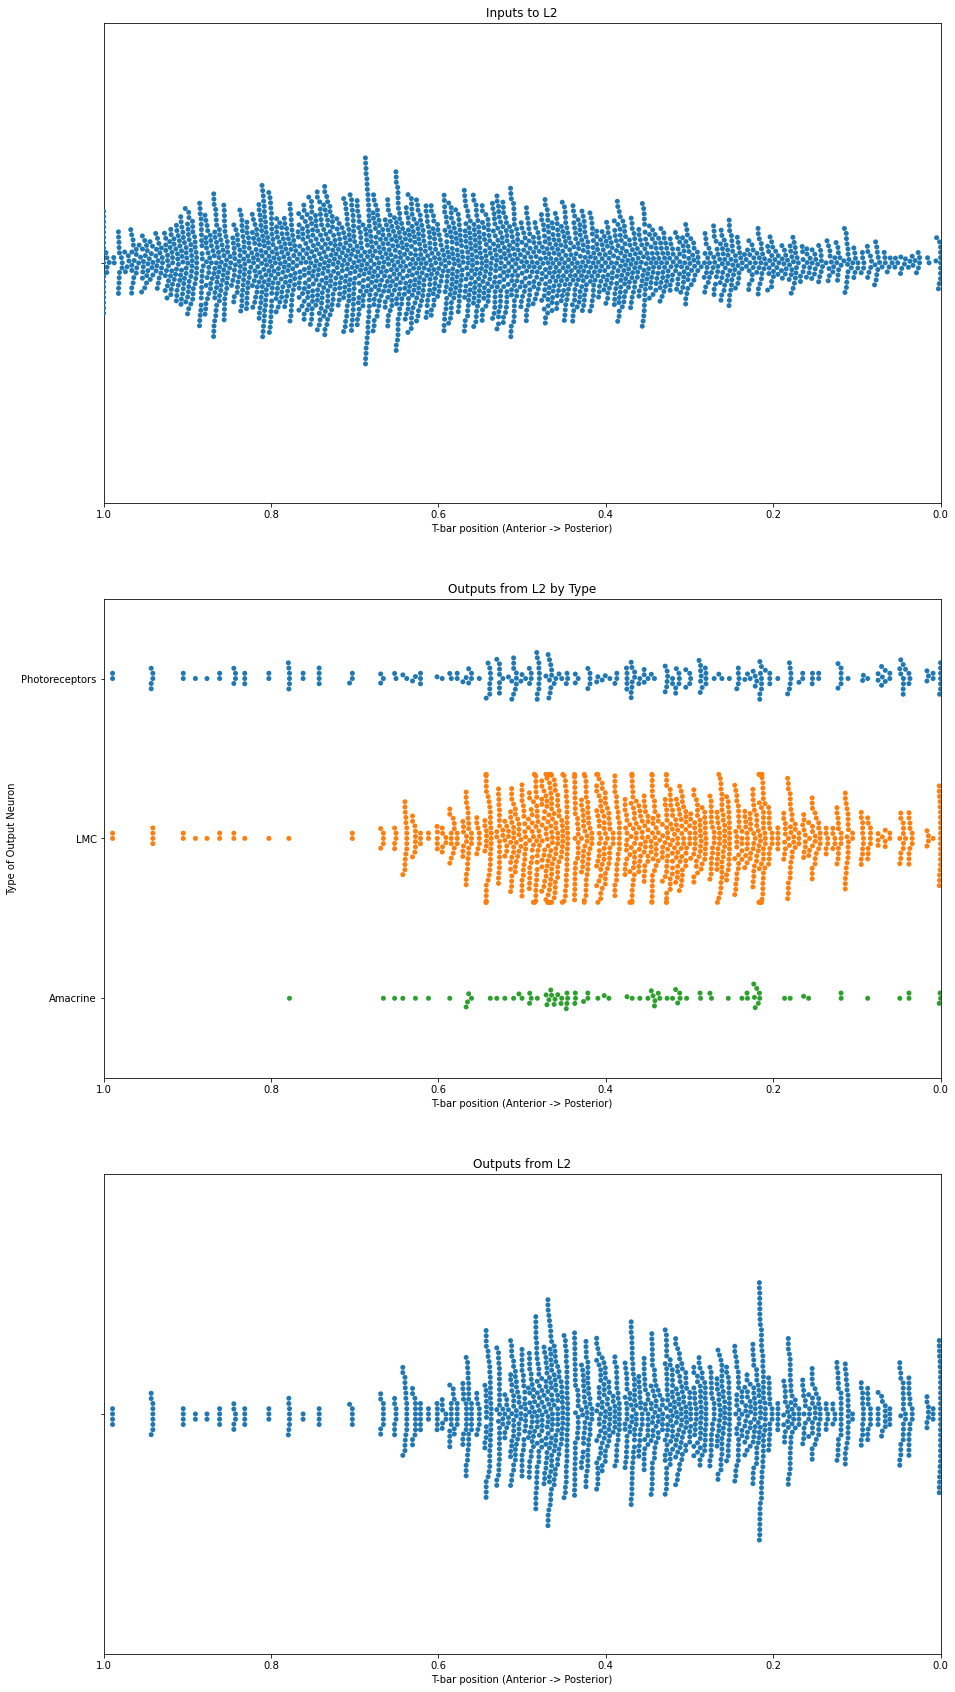

In [19]:
# Summary swarmplot

fig, ax = plt.subplots(3, figsize=[15, 30])

df_preL2['flag'] = LMCorNot(df_preL2)
display(df_preL2)

data_LMC = df_preL2.loc[(df_preL2['post_type'] != 'R1R4') & (df_preL2['post_type'] != 'R2R5') & (df_preL2['post_type'] != 'R3R6') & (df_preL2['post_type'] != 'R7') & (df_preL2['post_type'] != 'R7p') & (df_preL2['post_type'] != 'R8') & (df_preL2['post_type'] != 'LMC_N') & (df_preL2['post_type'] != 'centri')]
# data_notLMC = df_preL2.loc[(df_preL2['post_type'] != 'LMC_1') & (df_preL2['post_type'] != 'LMC_2') & (df_preL2['post_type'] != 'LMC_3') & (df_preL2['post_type'] != 'LMC_4')]
sns.swarmplot(x='transformed_coords', data=df_postL2, ax=ax[0])
ax[0].set_title('Inputs to L2')
ax[0].set_xlabel('T-bar position (Anterior -> Posterior)')
ax[0].set_xlim(1,0)

sns.swarmplot(x='transformed_coords', y='flag', data=df_preL2, ax=ax[1])
ax[1].set_title('Outputs from L2 by Type')
ax[1].set_xlabel('T-bar position (Anterior -> Posterior)')
ax[1].set_ylabel('Type of Output Neuron')
ax[1].set_xlim(1,0)

sns.swarmplot(x='transformed_coords', data=df_preL2, ax=ax[2])
ax[2].set_title('Outputs from L2')
ax[2].set_xlabel('T-bar position (Anterior -> Posterior)')
ax[2].set_xlim(1,0)


# sns.swarmplot(x='transformed_coords', data=df_preL2, ax=ax[1])

,cx_id,pre_om,pre_type,post_om,post_type,x,y,z,transformed_coords,flag
475,31171,A3,LMC_2,A3,R7p,32327.0,66283.5,25248.0,0.491340,Photoreceptors
476,31171,A3,LMC_2,A3,LMC_3,32327.0,66283.5,25248.0,0.491340,LMC
478,31171,A3,LMC_2,A3,LMC_1,32327.0,66283.5,25248.0,0.491340,LMC
479,31176,A3,LMC_2,A3,centri,31808.0,67053.1,25034.0,0.401843,Amacrine
480,31176,A3,LMC_2,A3,LMC_1,31808.0,67053.1,25034.0,0.401843,LMC
...,...,...,...,...,...,...,...,...,...,...
20440,479829,C2,LMC_2,C2,LMC_2,28960.0,70026.0,34412.0,0.516231,LMC
20441,479829,C2,LMC_2,C2,LMC_1,28960.0,70026.0,34412.0,0.516231,LMC
20442,479829,C2,LMC_2,C2,R7p,28960.0,70026.0,34412.0,0.516231,Photoreceptors
20443,481900,C2,LMC_2,C2,LMC_1,28727.0,68589.0,33325.0,0.445979,LMC


[0.49134028 0.49134028 0.40184301 ... 0.51623134 0.44597863 0.44597863]


/Users/deenashefter/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(array([[ 77., 124., 243., 241., 297., 163.,  44.,   3.,   8.,   8.],
        [113., 147., 285., 282., 341., 204.,  57.,  18.,  21.,  17.],
        [120., 153., 300., 300., 367., 215.,  62.,  19.,  21.,  17.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 Lists of Patches objects>)

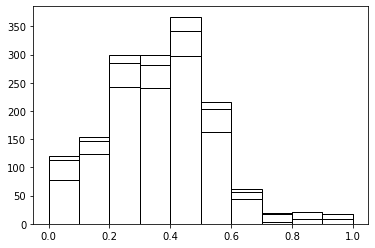

In [45]:
# Stacked Outputs from L2

df_preL2['flag'] = LMCorNot(df_preL2)
display(df_preL2)

lmc = np.array(df_preL2.loc[df_preL2['flag'] == 'LMC']['transformed_coords'])
print(lmc)
pr = np.array(df_preL2.loc[df_preL2['flag'] == 'Photoreceptors']['transformed_coords'])
amacrine = np.array(df_preL2.loc[df_preL2['flag'] == 'Amacrine']['transformed_coords'])

plt.hist([lmc, pr, amacrine], range=(0,1), stacked=True, fill=False)
# plt.hist(pr, stacked=True)
# plt.hist(amacrine, stacked=True)
# ax[0].set_title('Inputs to L2')
# ax[0].set_xlabel('T-bar position (Anterior -> Posterior)')
# ax[0].set_xlim(1,0)

In [ ]:
# Check for correct sign by comparing max untransformed coord with max transformed
# Average over all ommatidia (divide number of coordinates by 29), shape of hist should stay the same, gives per om average
# Print individual oms too, put subtypes together!!!!
# Compare between subtypes - focus on L2 as pre, looks like they're all segregated, calculate skew between different subtypes!!!!
# Calculate skew for totals, and for each om!!!!
# Take out ones that have little data to reduce clutter
# Look for current injection - if I inject something into the cell body, how is that different from injecting it into axon hillock